# 图像处理

- 图像以RGB存储，每个0-255 一个字节
- 每个像素对应一个RGB值
- 也可灰度模式：0-255 一个字节

## PIL 图像处理库

`pip install pillow`

使用
```py
from PIL import Image
```

Image是PIL库中代表一个图像的类

### 测试一些方法和成员

- `mode` 颜色模式
    - 1：1位像素，表示黑和白，但是存储的时候每个像素存储为8bit。
    - L：8位像素，表示黑和白。
    - P：8位像素，使用调色板映射到其他模式。
    - RGB：3x8位像素，为真彩色。
    - RGBA：4x8位像素，有透明通道的真彩色。
    - CMYK：4x8位像素，颜色分离。
    - YCbCr：3x8位像素，彩色视频格式。
    - I：32位整型像素。黑白图像
    - F：32位浮点型像素。黑白图像
- `size`

方法
- `convert(mode)` 切换颜色模式
- `getchannel(channel)` 传入对应的通道 "R"、"G"...
- `thumbnail(size)` ！改变了原来的图像
    - `thumbnail(size, resample, reducing_gap)`
- `transpose()` 旋转图像只能 90度地转
    - `Image.ROTATE_90,Image.ROTATE_180,Image.ROTATE_270`
- `rotate(angle)` 逆时针转动图像
- 更改、获取像素值
    - `getpixel(xy)` 如：(100,100)
    - `putpixel(xy, value)`

In [1]:
from PIL import Image

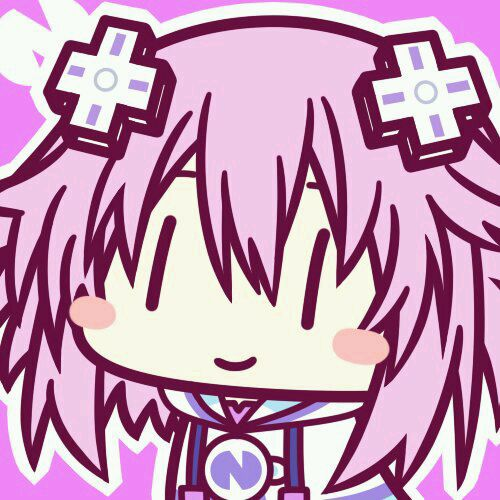

In [2]:
nep_img = Image.open("assets/nep.jpg")
nep_img # 为啥底下有个横线白色横线？ 好像是输出的问题

In [3]:
nep_img.mode

'RGB'

In [4]:
nep_img.size

(500, 500)

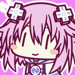

In [5]:
nep_copy = nep_img.copy()
nep_copy.thumbnail((75, 75))
nep_copy

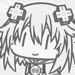

In [6]:
nep_copy.getchannel("R") # RGB

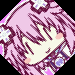

In [7]:
nep_copy.rotate(45)

In [8]:
nep_copy.getpixel((5, 5))

(247, 252, 246)

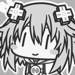

In [9]:
nep_copy.convert('L')

## 图像转换

即对每个像素的RGB进行运算就改变了图像

- 图像就是像素的二维数组
- 像素是由RGB的一维数据组成
- 所以图像为RGB三维数组？
- 所以就可以使用`NumPy`进行处理

In [10]:
import numpy as np

In [11]:
nep_arr = np.array(nep_copy)
nep_arr.shape, nep_arr.dtype, nep_arr[:2, :2, :]

((75, 75, 3),
 dtype('uint8'),
 array([[[238, 134, 242],
         [239, 131, 246]],
 
        [[237, 136, 244],
         [239, 180, 243]]], dtype=uint8))

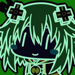

In [12]:
rgb255 = np.array((255,255,255), np.uint8) # 直接生成 uint8 的 ndarray
                                           # 加快运行速度，不用类型转换
nep_invert = rgb255 - nep_arr # 处理每个像素
nep_invert = Image.fromarray(nep_invert)
nep_invert  # 是真的绿哈

In [13]:
nep_larr = np.array(nep_copy.convert('L')) # 转换成灰度模式
nep_larr.shape, nep_larr.dtype, nep_arr[:2, :2]

((75, 75),
 dtype('uint8'),
 array([[[238, 134, 242],
         [239, 131, 246]],
 
        [[237, 136, 244],
         [239, 180, 243]]], dtype=uint8))

### 变淡

arr * (100/255) + 150 # 区间变换

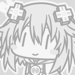

In [14]:
nep_light = nep_larr * (100/255) + 150 # 区间变换nd
# 我tm爱了，NumPy不是C写出来的吗， u8 / u8 的结果竟然是 f64
# 不过 u8 确实放不下 100 * 255，那至少 结果是int吧
Image.fromarray(nep_light.astype(np.uint8))

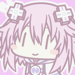

In [15]:
nep_light = nep_arr * (100/255) + 150 # 区间变换
Image.fromarray(nep_light.astype(np.uint8))

### 变深

255 * (arr / 255) ** 2 # 像素平方

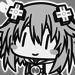

In [16]:
nep_dark = 255 * (nep_larr / 255) ** 2 # 像素平方
Image.fromarray(nep_dark.astype(np.uint8))

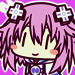

In [17]:
nep_dark = 255 * (nep_arr / 255) ** 2 # 像素平方
Image.fromarray(nep_dark.astype(np.uint8))

## 手绘案例

- 黑白灰色
- 边界线条较重
- 相同或相近色彩趋于白色
- 略有光源效果

![坐标系](assets/drawing-coordinate.png)

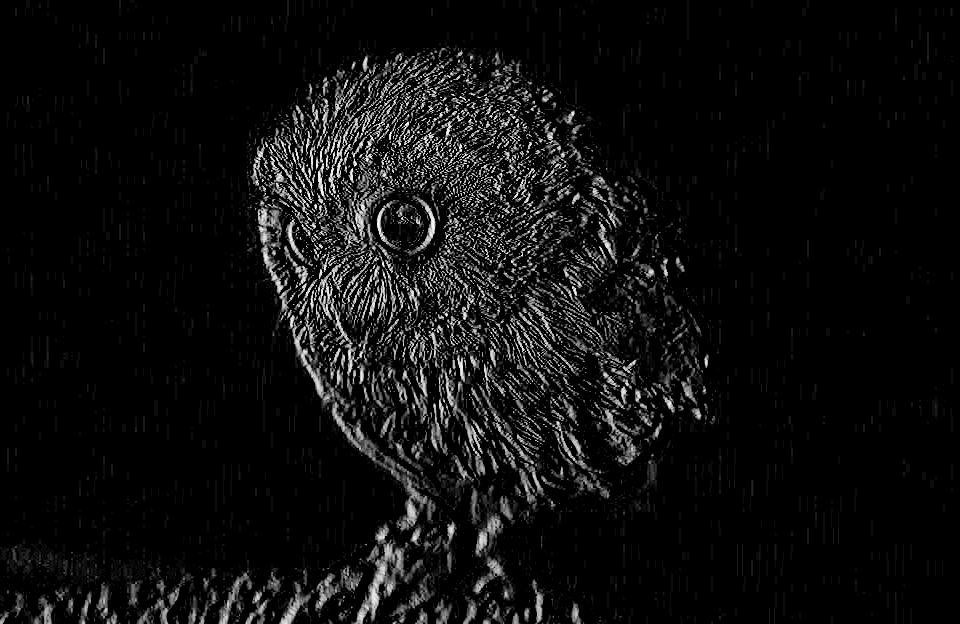

In [18]:
a = np.array(Image.open("assets/owl.jpg").convert('L'))

depth = 10. 						# (0-100)
grad = np.gradient(a)				#取图像灰度的梯度值
grad_x, grad_y = grad 				#分别取横纵图像梯度值
grad_x = grad_x*depth/100.
grad_y = grad_y*depth/100.
A = np.sqrt(grad_x**2 + grad_y**2 + 1.)

uni_x = grad_x/A    # 图像平面的单位法向量
uni_y = grad_y/A
uni_z = 1./A

vec_el = np.pi/1 		        # 光源的俯视角度，弧度值 原 2.2
# pi 为 180ᐤ  朝着摄像机，所以全是阴影？
vec_az = np.pi/2 					# 光源的方位角度，弧度值 原 4
dx = np.cos(vec_el)*np.cos(vec_az) 	#光源对 x 轴的影响
dy = np.cos(vec_el)*np.sin(vec_az) 	#光源对 y 轴的影响
dz = np.sin(vec_el) 				#光源对 z 轴的影响

b = 255*(dx*uni_x + dy*uni_y + dz*uni_z) 	#光源归一化
b = b.clip(0,255)  # 防止越界

Image.fromarray(b.astype(np.uint8)) 	#重构图像

效果很一般